**Allen-Cahn equation**

Retyped by Theodoret Putra Agatho on 6 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/allen.cahn.html)

**ReadMe!**
Before running this notebook in google colab, it's required to upload "Allen_Cahn.mat" file in google colab files section.

In [1]:
pip install deepxde

**Problem setup**

We will solve an Allen-Cahn equation:

\begin{align}
        \frac{\partial u}{\partial t} = d \frac{\partial ^2 u}{\partial x^2} + 5 (u - u^3), x \in [-1, 1], t \in [0,1]
    \end{align}

The initial condition is defined as the following:

\begin{align}
        u(x,0) = x^2 \text{cos}(\pi x)
    \end{align}

And the boundary condition is defined:

\begin{align}
        u(-1, t) = u(1, t) = -1
    \end{align}

The reference solution is [here](https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Allen_Cahn.mat)

**Implementation**

Thhis description goes through the implementation of a solver for the above described Allen-Cahn equation step-by-step.

First, the DeepXDE, NumPy (`np`), Scipy, and TensorFlow (`tf`) modules are imported:

In [2]:
import deepxde as dde
import numpy as np
from scipy.io import loadmat
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We then begin by defining a computational geometry and a time domain. We can use a built-in class `Interval` and `TimeDomain`, and we can combine both of the domains using `GeometryXTime`.

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Now, we express the PDE residual of the Allen-Cahn equation:

In [4]:
d = 0.001
def pde(x, y):
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t - d * dy_xx - 5 * (y - y**3)

The first argument to `pde` is a 2-dimensional vector where the first component(`x[:, 0]`) is $x$-coordinate and the second component(`x[:,1]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x, t)$, but here we use `y` as the name of the variable.

Now that we have specified the geometry and PDE residual, we can define the `TimePDE` problem as the following:

In [5]:
data = dde.data.TimePDE(geomtime, pde, [], num_domain=8000, num_boundary=400, num_initial=800)

The parameter `num_domain=8000` is the number of training residual points sampled inside the domain, and the parameter `num_boundary=400` is the number of training points sampled on the boundary. We also include the parameter `num_initial=800`, which represents the number of initial residual points for the initial conditions.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:

In [6]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Next, we consider the initial conditions and boundary constraints, defining the transformation of the output and applying it to the network. In this case, $x^2 \text{cos} (\pi x) + t(1 - x^2) y$ is used. When $t = 0$, the initial condition $x^2 \text{cos} (\pi x)$ is satisfied. When $x = 1$ or $x = -1$, the boundary condition $y(-1, t) = y(1, t) = -1$ is satisfied. This demonstrates that the initial condition and the boundary constraint are both hard conditons.

In [7]:
def output_transform(x, y):
  return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

net.apply_output_transform(output_transform)

Now that we have defined the neural network, we build a `Model`, choose the optimizer and learning rate (`lr`), and train it for 40000 iterations:

In [8]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(iterations=40000)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.446194 s

'compile' took 3.111742 s

Training model...

Step      Train loss    Test loss     Test metric
0         [7.84e-01]    [7.84e-01]    []  
1000      [6.33e-02]    [6.33e-02]    []  
2000      [1.35e-02]    [1.35e-02]    []  
3000      [1.05e-02]    [1.05e-02]    []  
4000      [9.09e-03]    [9.09e-03]    []  
5000      [8.24e-03]    [8.24e-03]    []  
6000      [7.68e-03]    [7.68e-03]    []  
7000      [7.33e-03]    [7.33e-03]    []  
8000      [7.08e-03]    [7.08e-03]    []  
9000      [6.98e-03]    [6.98e-03]    []  
10000     [6.60e-03]    [6.60e-03]    []  
11000     [6.36e-03]    [6.36e-03]    []  
12000     [6.06e-03]    [6.06e-03]    []  
13000     [5.66e-03]    [5.66e-03]    []  
14000     [5.65e-03]    [5.65e-03]    []  
15000     [5.13e-03]    [5.13e-03]    []  
16000     [4.99e-03]    [4.99e-03]    []  
17000     [4.85e-03]    [4.85e-03]    []  
18000     [4.75e-03]    [4.75e-03]    []  
19000     [4.66e-03]    [4.66e-03]    []  
20000     [4.54e-03

(<deepxde.model.LossHistory at 0x7b56fdb56e90>,
 <deepxde.model.TrainState at 0x7b56fdb56230>)

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [9]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.557682 s

Training model...

Step      Train loss    Test loss     Test metric
40000     [3.72e-04]    [3.72e-04]    []  
41000     [9.66e-05]    [9.66e-05]        
42000     [5.48e-05]    [5.48e-05]        
43000     [3.62e-05]    [3.62e-05]        
44000     [2.45e-05]    [2.45e-05]        
45000     [1.59e-05]    [1.59e-05]        
46000     [1.21e-05]    [1.21e-05]        
47000     [9.02e-06]    [9.02e-06]        
48000     [6.94e-06]    [6.94e-06]        
49000     [5.79e-06]    [5.79e-06]        
50000     [4.97e-06]    [4.97e-06]        
50604     [4.60e-06]    [4.60e-06]    []  

Best model at step 50604:
  train loss: 4.60e-06
  test loss: 4.60e-06
  test metric: []

'train' took 391.427275 s



We then save and plot the best trained result and the loss history of the model.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


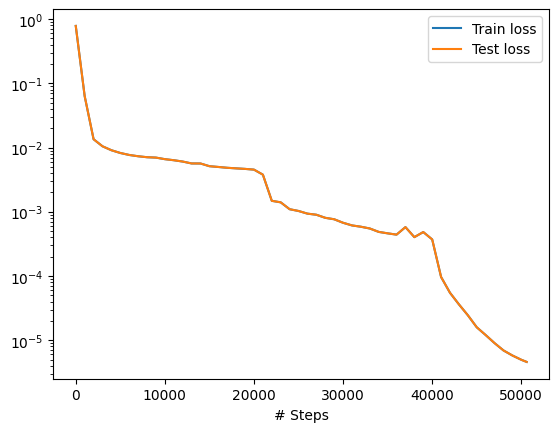

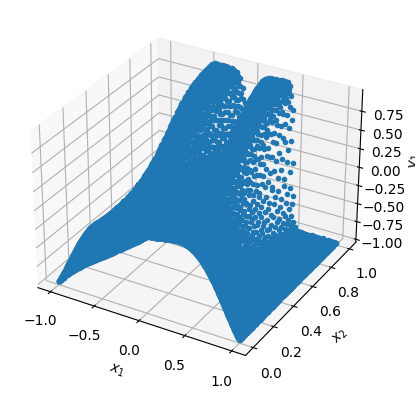

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Next, we load and prepare the dataset with `gen_testdata()`. Finally, we test the model and display a graphh containing bboth training loss and testing loss over time. We also display a graph containing thhe predicted solution to the PDE.

In [11]:
def gen_testdata():
  data = loadmat("Allen_Cahn.mat")

  t = data["t"]
  x = data["x"]
  u = data["u"]

  dt = dx = 0.01
  xx, tt = np.meshgrid(x, t)
  X = np.vstack((np.ravel(xx), np.ravel(tt))).T
  y = u.flatten()[:, None]
  return X,y

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.0015483226
L2 relative error: 0.006722960194883505
